<a href="https://colab.research.google.com/github/DestonSJU/GenAI/blob/main/Extra_Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//*** Deston Willis

//*** Generative AI

//*** 12/6/24

//*** Homework 6 Extra Credit: The purpose of this assignment is to create and train a model that can generate music in the style of Beethoven.

1. First I installed and imported various packages and modules. Next I mounted the google drive. I then loaded the midi files from google drive and displayed an example in text form. I used 20 midi files with piano music from Beethoven. Next I parsed the midi files and displayed an example of the notes. I then put them in a dataset to be used to train the model.

In [ ]:
!apt-get install musescore
import sys
!{sys.executable} -m pip install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [ ]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

In [ ]:
#Mounts google drive to download dataset from google drive
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from transformer_utils import parse_midi_files
from transformer_utils import load_parsed_files
from transformer_utils import get_midi_note
from transformer_utils import  SinePositionEncoding

In [ ]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

In [ ]:
# Paths
zip_file_path = '/content/drive/My Drive/Colab Notebooks/Beethoven_Piano.zip'
extract_to = '/content/'

# Extract the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')

['.config', 'drive', 'data', 'sample_data']

In [ ]:
# Load the data
file_list = glob.glob("/content/data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 20 midi files


In [ ]:
parser = music21.converter

In [ ]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [ ]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7ea13704fe20>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=112>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 1/4>
    {0.0} <music21.chord.Chord G4 B4>
    {0.75} <music21.chord.Chord A4 C5>
    {1.0} <music21.chord.Chord G2>
    {2.0} <music21.chord.Chord B2>
    {3.0} <music21.chord.Chord D3>
{1.0} <music21.stream.Measure 2 offset=1.0>
    {0.0} <music21.meter.TimeSignature 3/4>
    {0.0} <music21.chord.Chord G3 B4 D5>
    {0.75} <music21.chord.Chord G3 B-4 C#5>
    {1.0} <music21.chord.Chord G2 B4 D5>
    {1.75} <music21.chord.Chord G2 B-4 C#5>
    {2.0} <music21.chord.Chord B4 D5>
    {2.75} <music21.chord.Chord B-4 C#5>
    {3.0} <music21.chord.Chord D3>
{4.0} <music21.stream.Measure 3 offset=4.0>
    {0.0} <music21.chord.Chord D2 B4 D5>
    {1.0} <music21.chord.Chord B4 D5>
    

In [ ]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/minuetto_in_sol_op_49_n_2.mid


<ipython-input-11-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


1010 notes parsed
2 Parsing /content/data/Beethoven_Minuet_in_G_major_WoO_10_No._2.mid
1544 notes parsed
3 Parsing /content/data/Beethoven_-_Sonata_No._8_Op._13_Pathetique.mid
7620 notes parsed
4 Parsing /content/data/Beethoven_-_Sonata_No._14_Op._27_No._2_MondscheinMoonlight.mid
13345 notes parsed
5 Parsing /content/data/Fr_Elise.mid
14281 notes parsed
6 Parsing /content/data/sonate_01_(c)hisamori.mid
19648 notes parsed
7 Parsing /content/data/Beethoven_Symphony_No._7_2nd_movement_Piano_solo.mid
21864 notes parsed
8 Parsing /content/data/Beethoven_Sonata_Op._31_No._17_3rd_Movement_Tempest.mid
25889 notes parsed
9 Parsing /content/data/Beethoven_-_Piano_Sonata_No._20_in_G_Major_Op._49_1st_Movement.mid
27565 notes parsed
10 Parsing /content/data/score (1).mid
30269 notes parsed
11 Parsing /content/data/score.mid
32189 notes parsed
12 Parsing /content/data/Ludwig_Van_Beethoven_-_Ode_To_Joy_-_Piano_Arranged.mid
32851 notes parsed
13 Parsing /content/data/Beethoven_Symphony_No._6_Pastoral_

In [ ]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 B3 G5 D4 G5 B3 D4 C5 C5 E5 C:major A3 G5 D4 G5 G5 E5 D4 F5 G3 D5 D4 B3 C5 D4 C5 C4 G4 C5 C4 E5 rest B3 G5 rest G5 E5 rest F5 F#4 D5 F#4 G4 C5 rest G4 C5 B4 C5 rest D5 B4 ...

Duration string
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.25 0.25 0.0 0.5 0.5 0.5 0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.5 1.0 0.5 0.25 0.25 0.5 0.25 0.25 0.25 0.25 0.5 0.5 0.5 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.5 1.0 0.5 0.5 0.5 0.5 0.5 1.0 0.5 0.5 ...


In [ ]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2. Next, I tokenized the data and displayed some of the tokens. I then displayed some of the vocab (notes). I then set up the training data.

In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        38         3
         4         3
        20         3
         4         3
        38         3
        20         3
         3         3
         3         2
        12         2
        77        10
        26         3


In [ ]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 106
0: 
1: [UNK]
2: rest
3: C5
4: G5
5: D5
6: E-5
7: G4
8: A4
9: F5

DURATIONS_VOCAB: length = 35
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1/3
5: 1.0
6: 1/6
7: 1/12
8: 0.75
9: 2.0


In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [ ]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[18, 18, 18, ..., 10,  6, 10],
       [18, 18, 18, ...,  6, 10,  3],
       [18, 18, 18, ..., 10,  3, 17],
       ...,
       [ 6,  3, 34, ...,  6,  6,  2],
       [ 3, 34, 18, ...,  6,  2, 22],
       [34, 18, 11, ...,  2, 22, 11]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  2],
       [ 3,  3,  3, ...,  3,  2,  2],
       ...,
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  2, ...,  3,  3,  3],
       [ 3,  2,  2, ...,  3,  3, 27]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[18, 18, 18, ...,  6, 10,  3],
       [18, 18, 18, ..., 10,  3, 17],
       [18, 18, 18, ...,  3, 17, 38],
       ...,
       [ 3, 34, 18, ...,  6,  2, 22],
       [34, 18, 11, ...,  2, 22, 11],
       [18, 11, 18, ..., 22, 11, 22]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3,  3,  3, ...,  3,  3,  2],
       [ 3,  3,  3, ...,  3,  2, 

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

3. Next I set up classes to create a transformer block and embeddings respectively. I then displayed the embeddings. I then created and displayed the model. The model has 2 input layers for the notes and durations, two layers of embeddings for the notes and the durations, a concatenate layer, a layer for the transformer block, and two output layers for the notes and durations.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

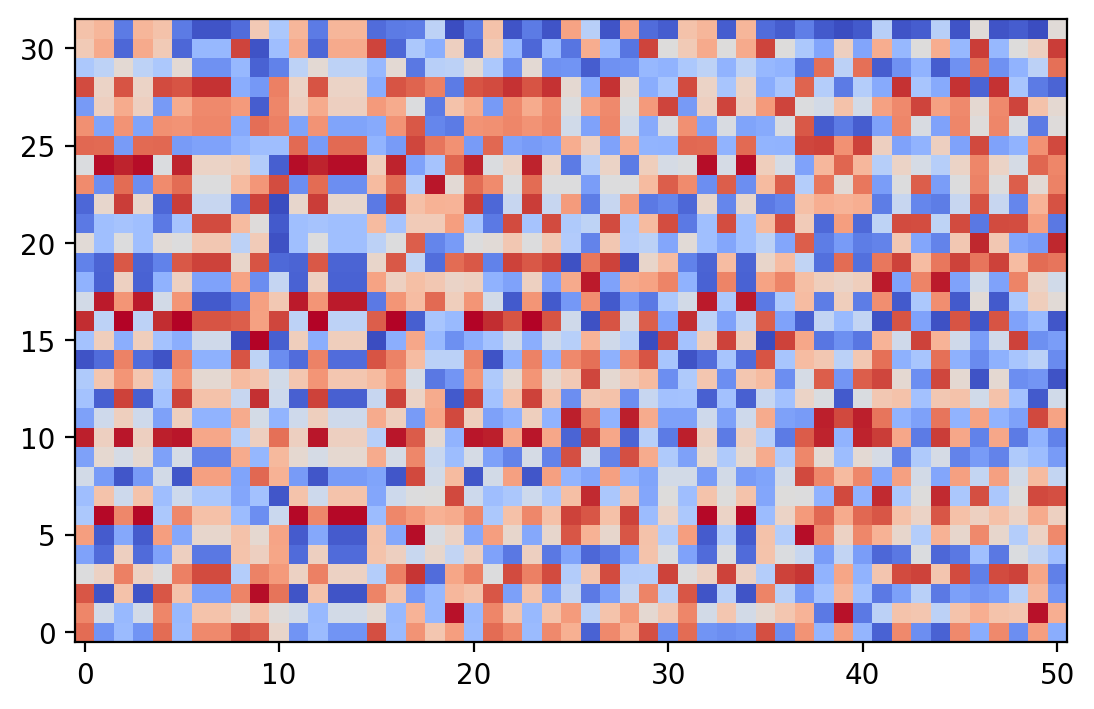

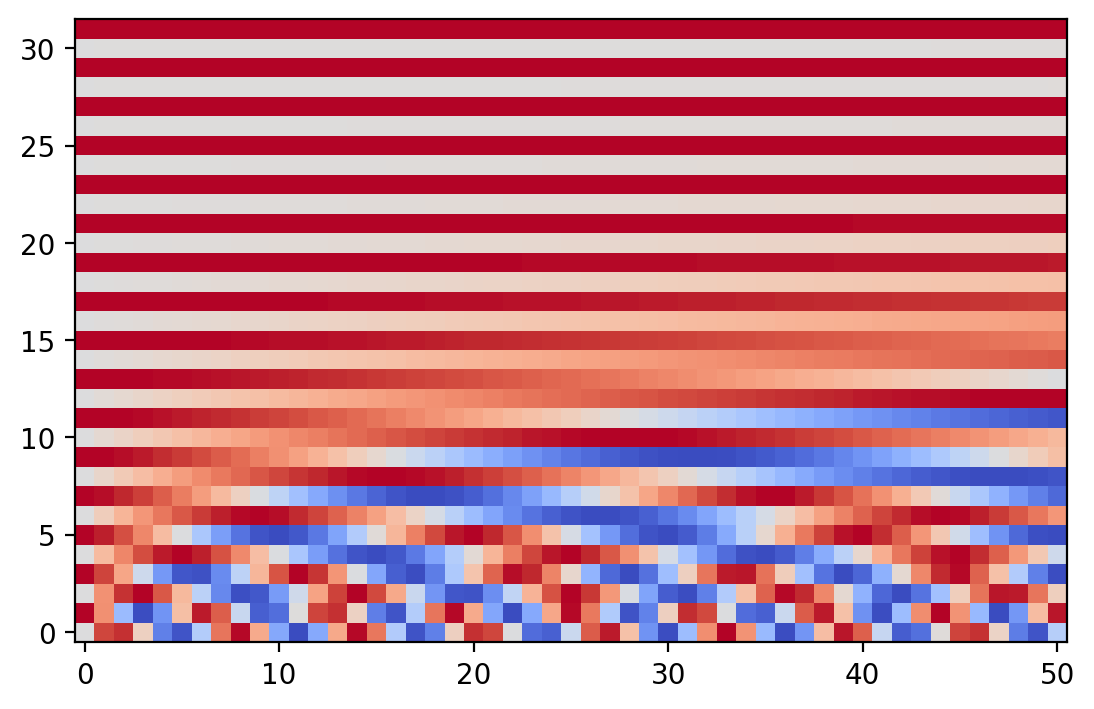

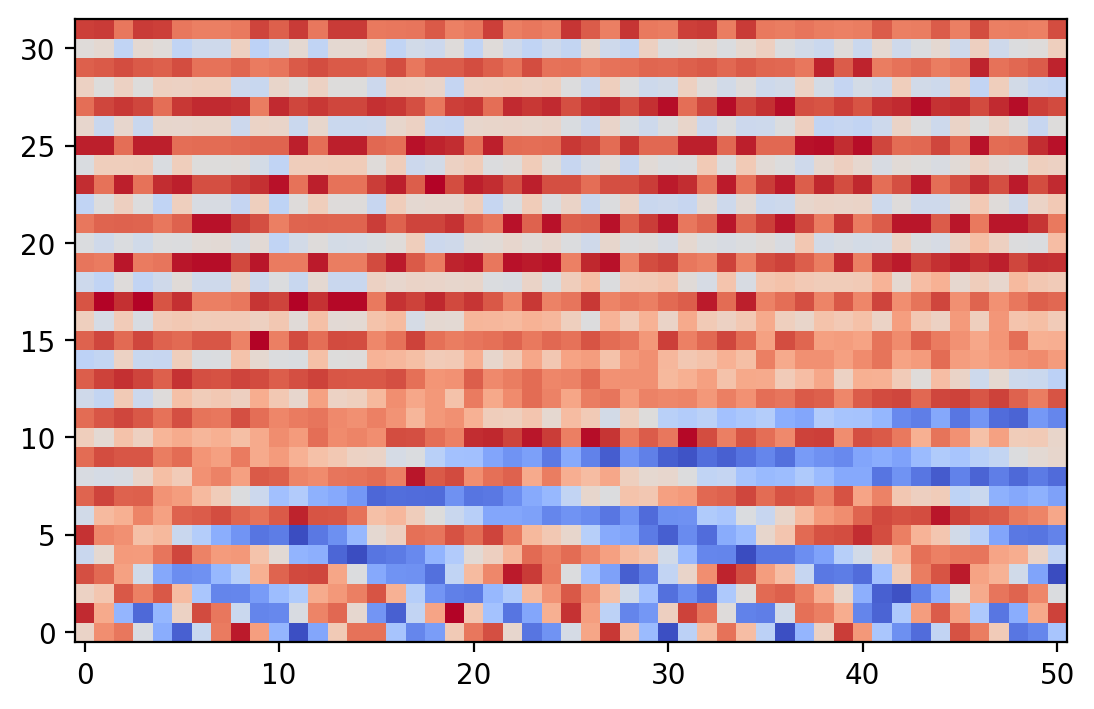

In [ ]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │         13,568 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          4,480 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 106)      │         27,242 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 35)       │          8,995 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,501,709 (5.73 MB)

 Trainable params: 1,501,709 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

4. Next, I trained the model for 50 epochs. After each epoch I had the model generate music and store it in the outputs folder. These are the model statistics after 50 epochs: duration_outputs_loss: 0.7710 - loss: 2.6437 - note_outputs_loss: 1.8726. I also have the music generated from epoch 50 below.

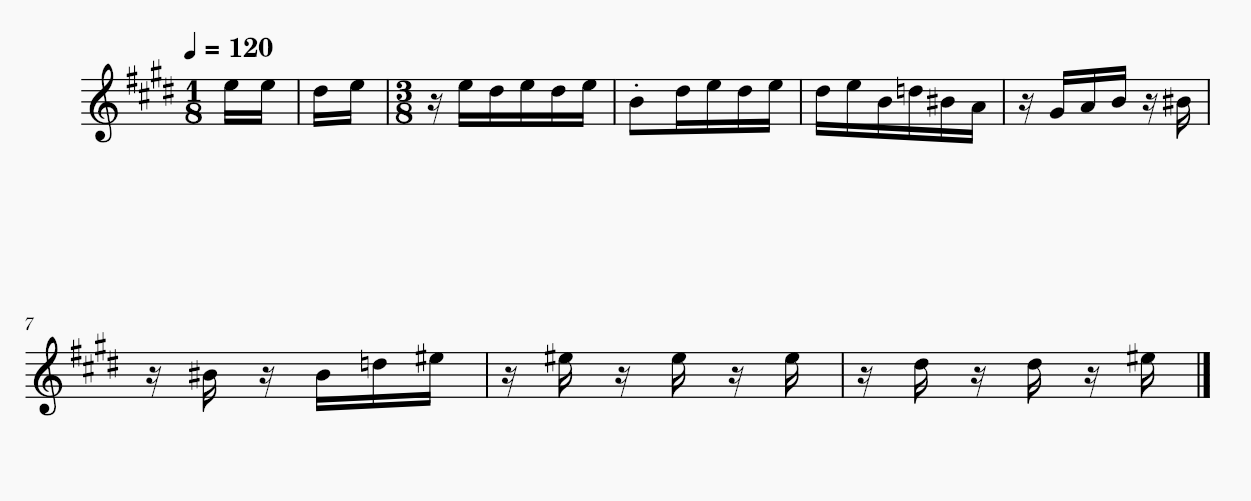

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [ ]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
os.mkdir('/content/output')

In [ ]:
model.fit(
    ds,
    epochs=50,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/50
197/198 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - duration_outputs_loss: 1.6279 - loss: 5.8204 - note_outputs_loss: 4.1925

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'rest', 'A4', 'A4', 'G4', 'G4', 'G4', 'G4', 'A4', 'A4', 'rest', 'A4', 'A4', 'rest', 'E4', 'rest', 'A4', 'A4', 'F4', 'rest', 'rest', 'C4', 'A4', 'E4', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'rest', 'rest', 'A4', 'C5', 'C5', 'B4', 'B4', 'B4', 'G4', 'G4', 'A4', 'B4', 'rest'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]
198/198 ━━━━━━━━━━━━━━━━━━━━ 107s 487ms/step - duration_outputs_loss: 1.6238 - loss: 5.8143 - note_outputs_loss: 4.1905
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - duration_outputs_loss: 0.9509 - loss: 4.2591 - note_outputs_loss: 3.3082[['START', 'rest', 'rest', 'rest', 'E-5', 'E-5', 'E-5', 'E-5', 'E-5', 'E-5', '

In [ ]:
# Save the final model
model.save("/content/model", zipped=False)

5. Finally, I used the model to generate 3 sets of music. I had it generate music with a temperature of 0.1, 0.5, and 1. I then saved the model, the training data, the training outputs, and the 3 generated sets of music.

Generated Music 1 (Temperature of 0.1):

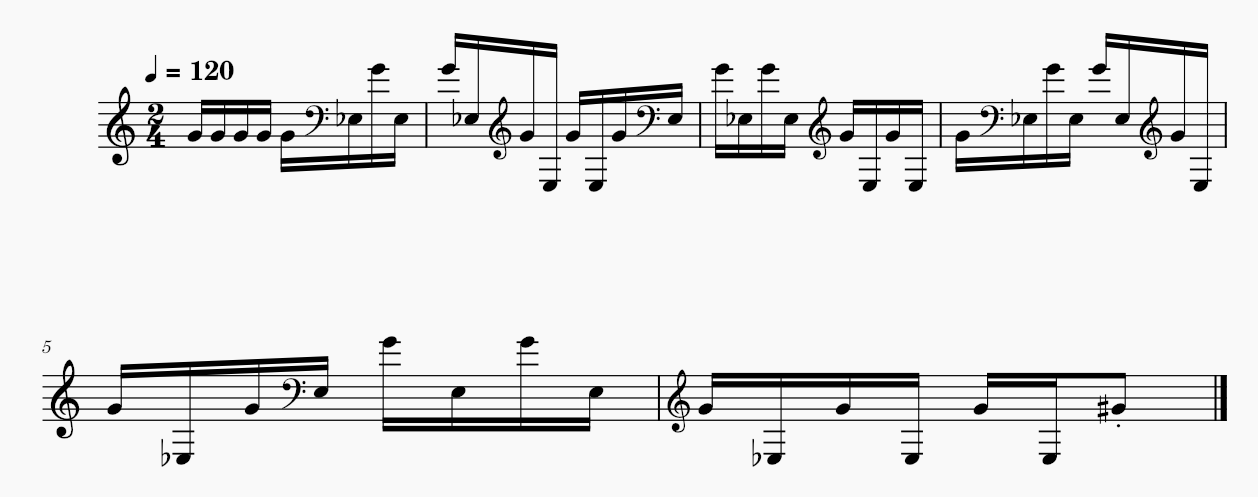

Generated Music 2 (Temperature of 0.5):

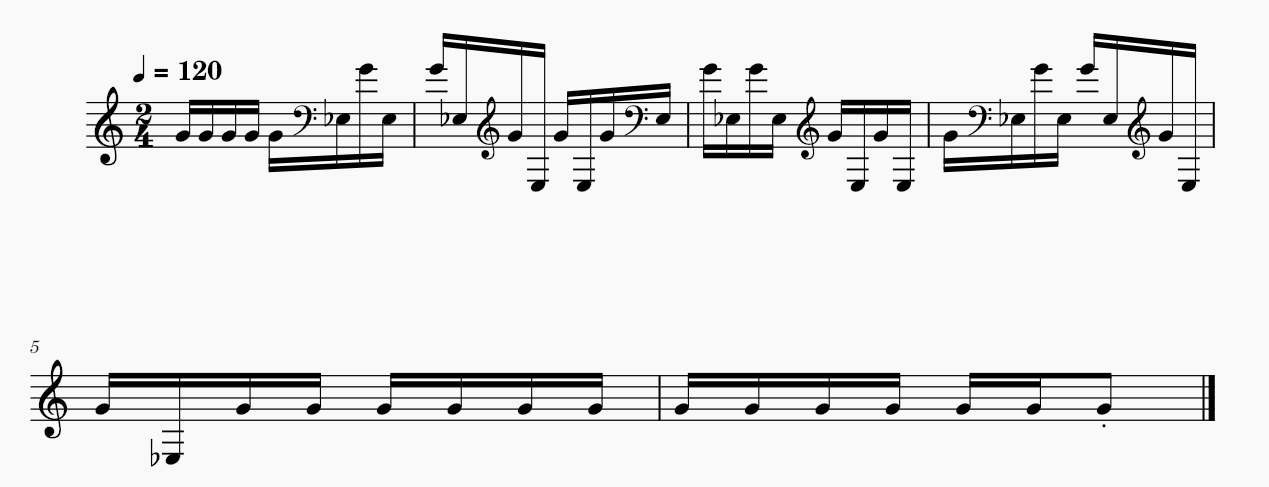

Generated Music 3 (Temperature of 1):

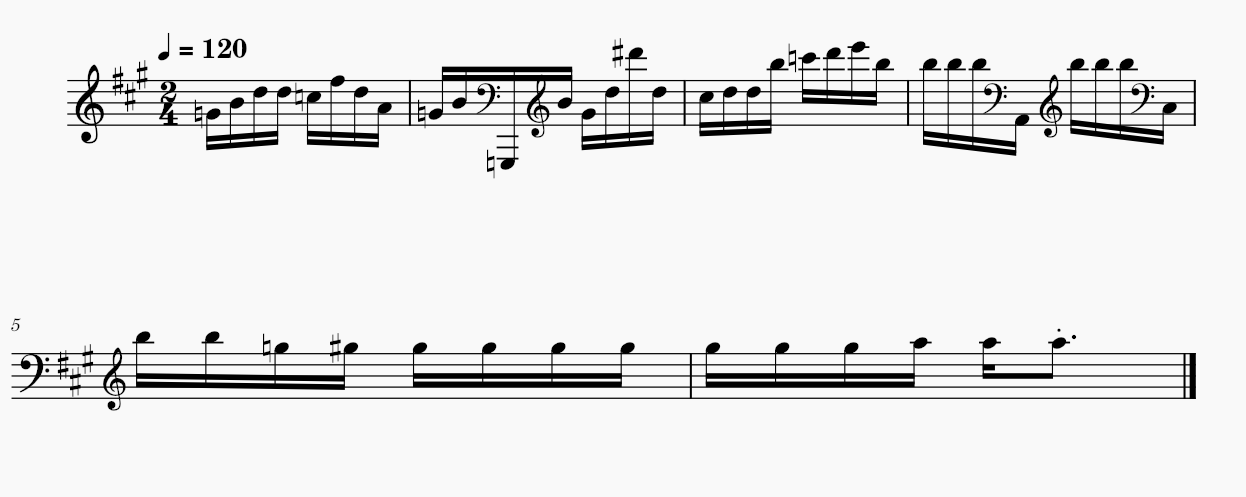

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.1
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

In [ ]:
os.mkdir('/content/transformer_output1')

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output1",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output1/output-20241206-232737.mid'

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

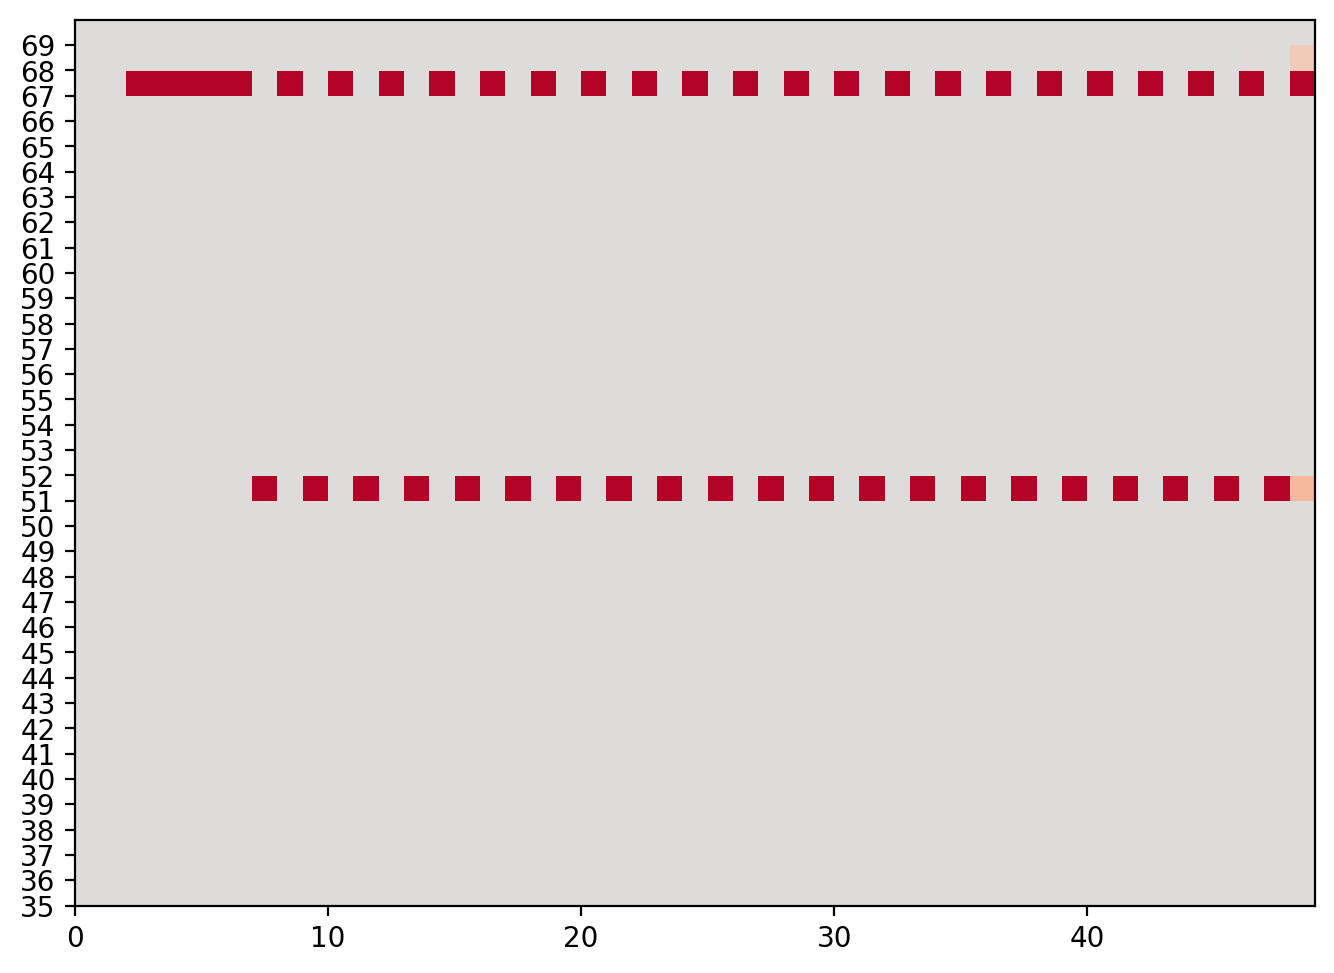

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

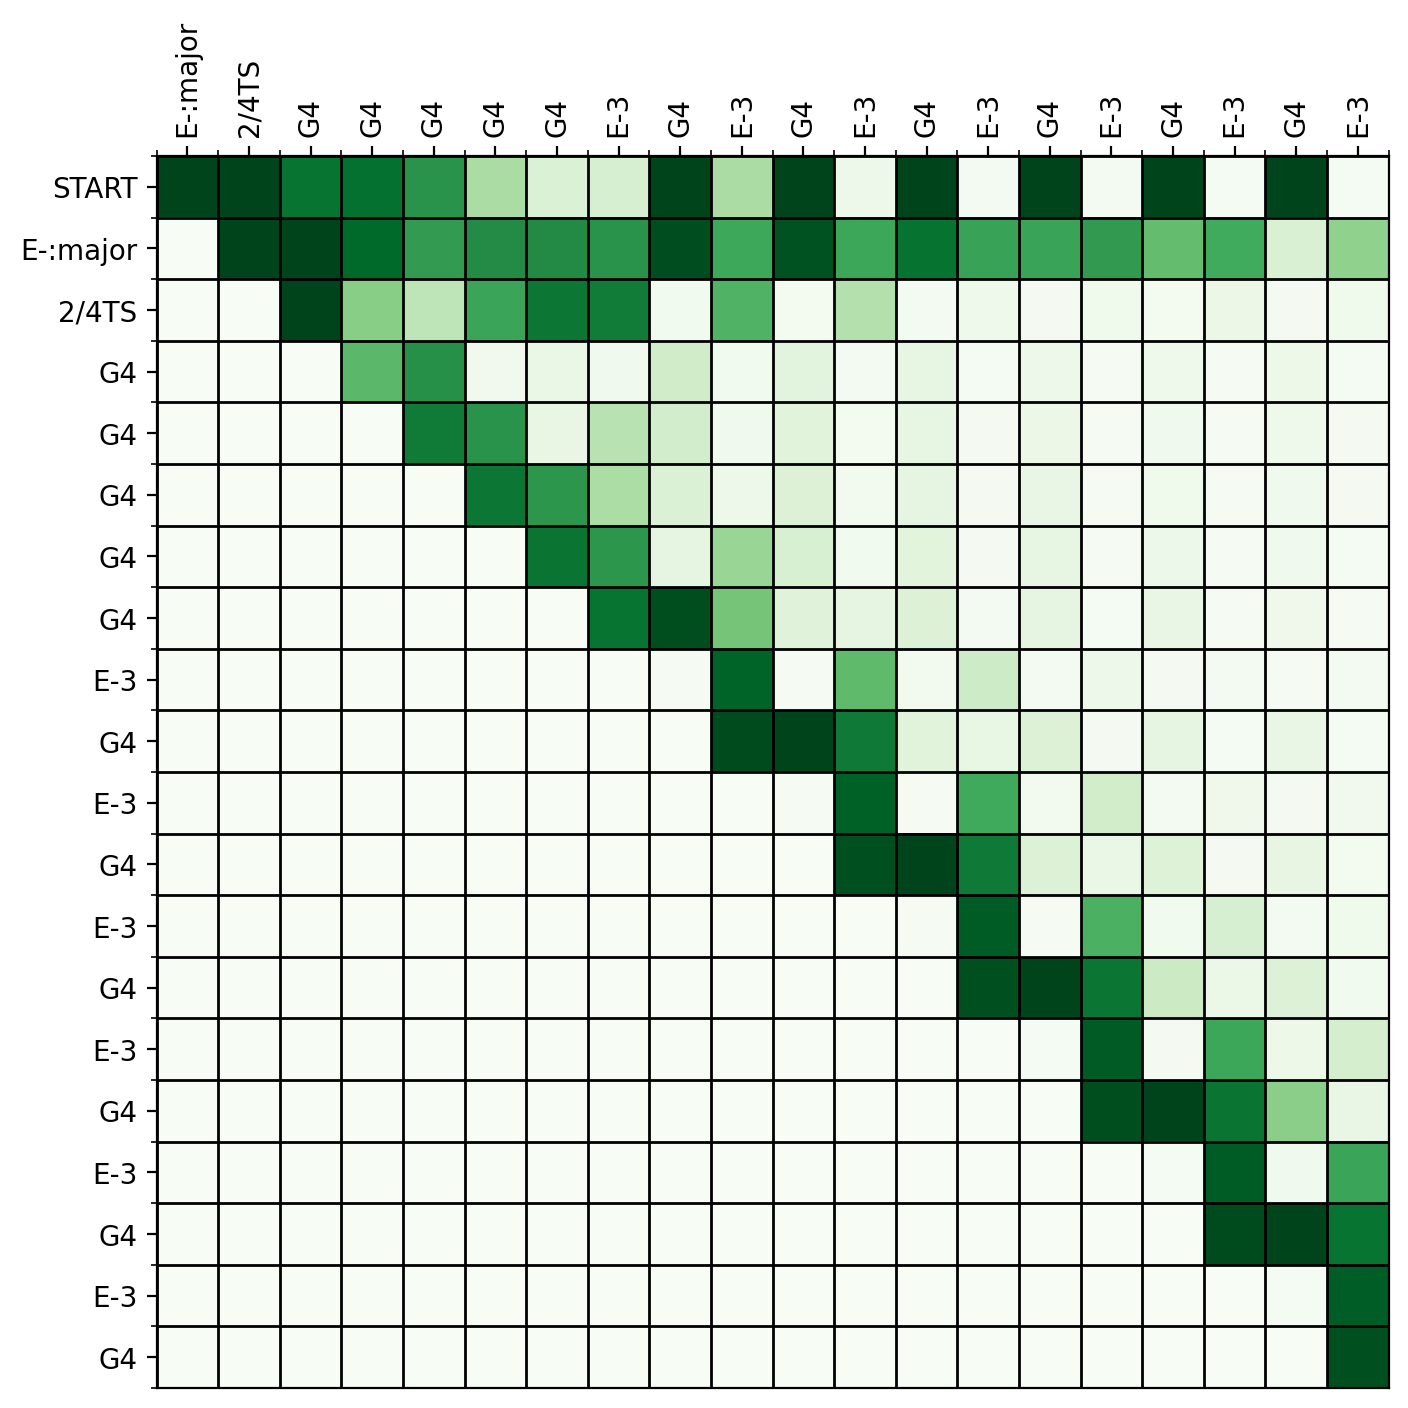

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
os.mkdir('/content/transformer_output2')

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output2",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output2/output-20241206-232827.mid'

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

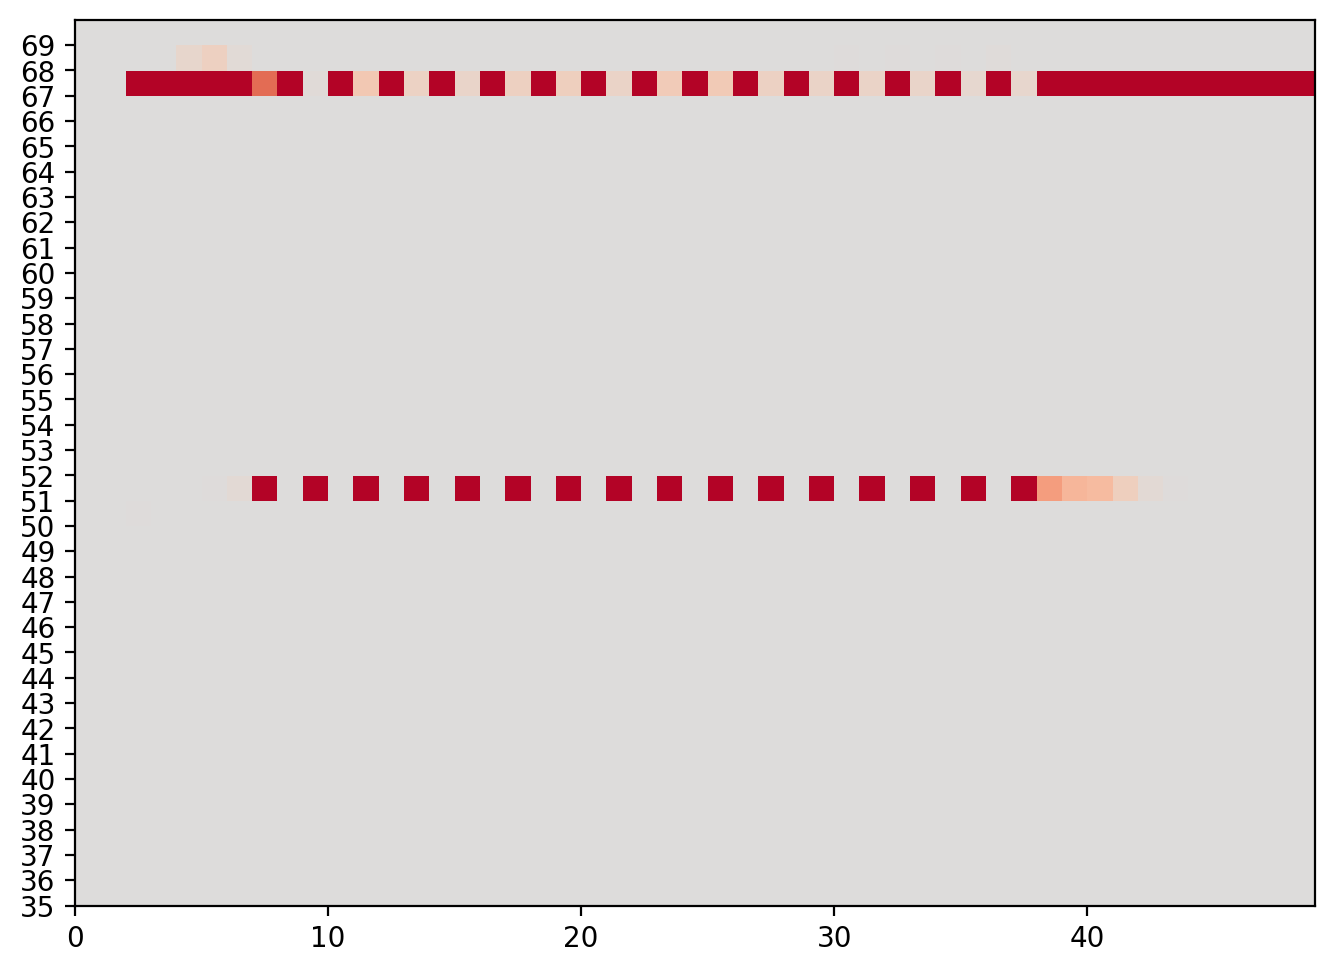

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

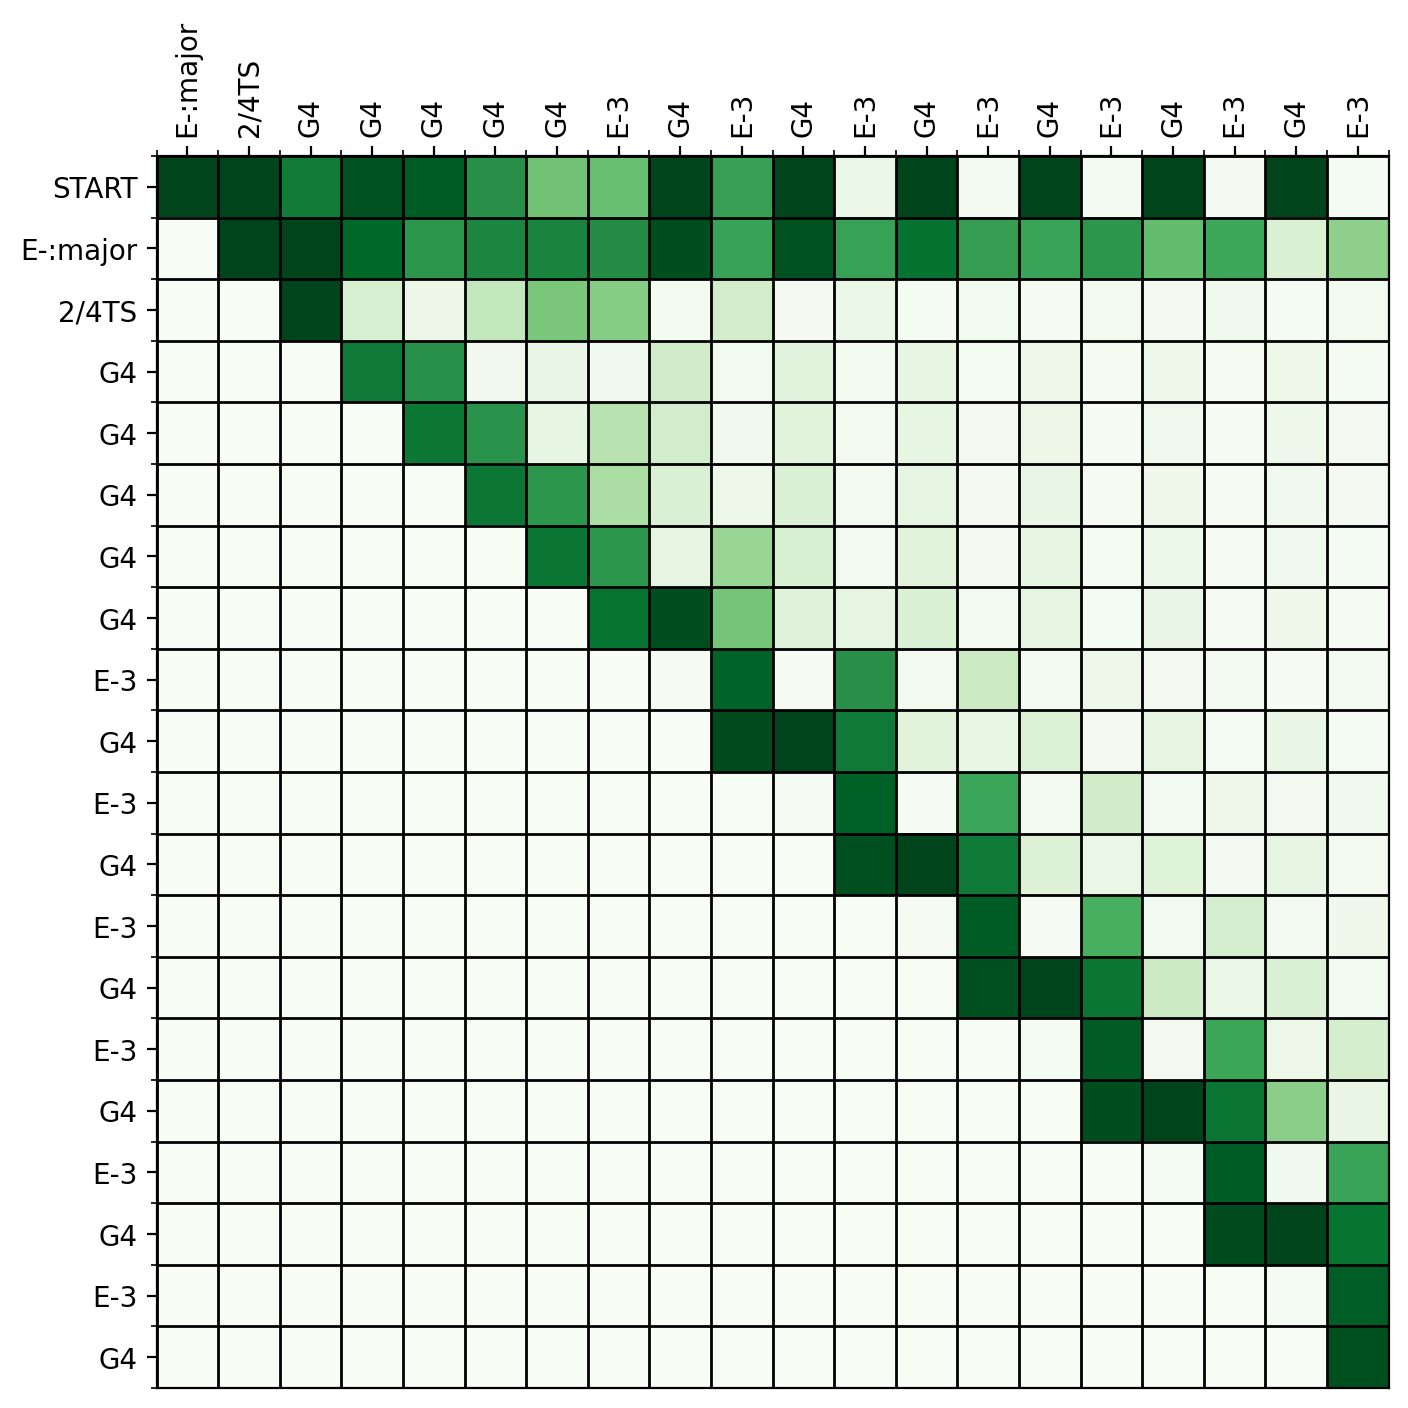

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1.0
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
os.mkdir('/content/transformer_output3')

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output3",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output3/output-20241206-232929.mid'

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

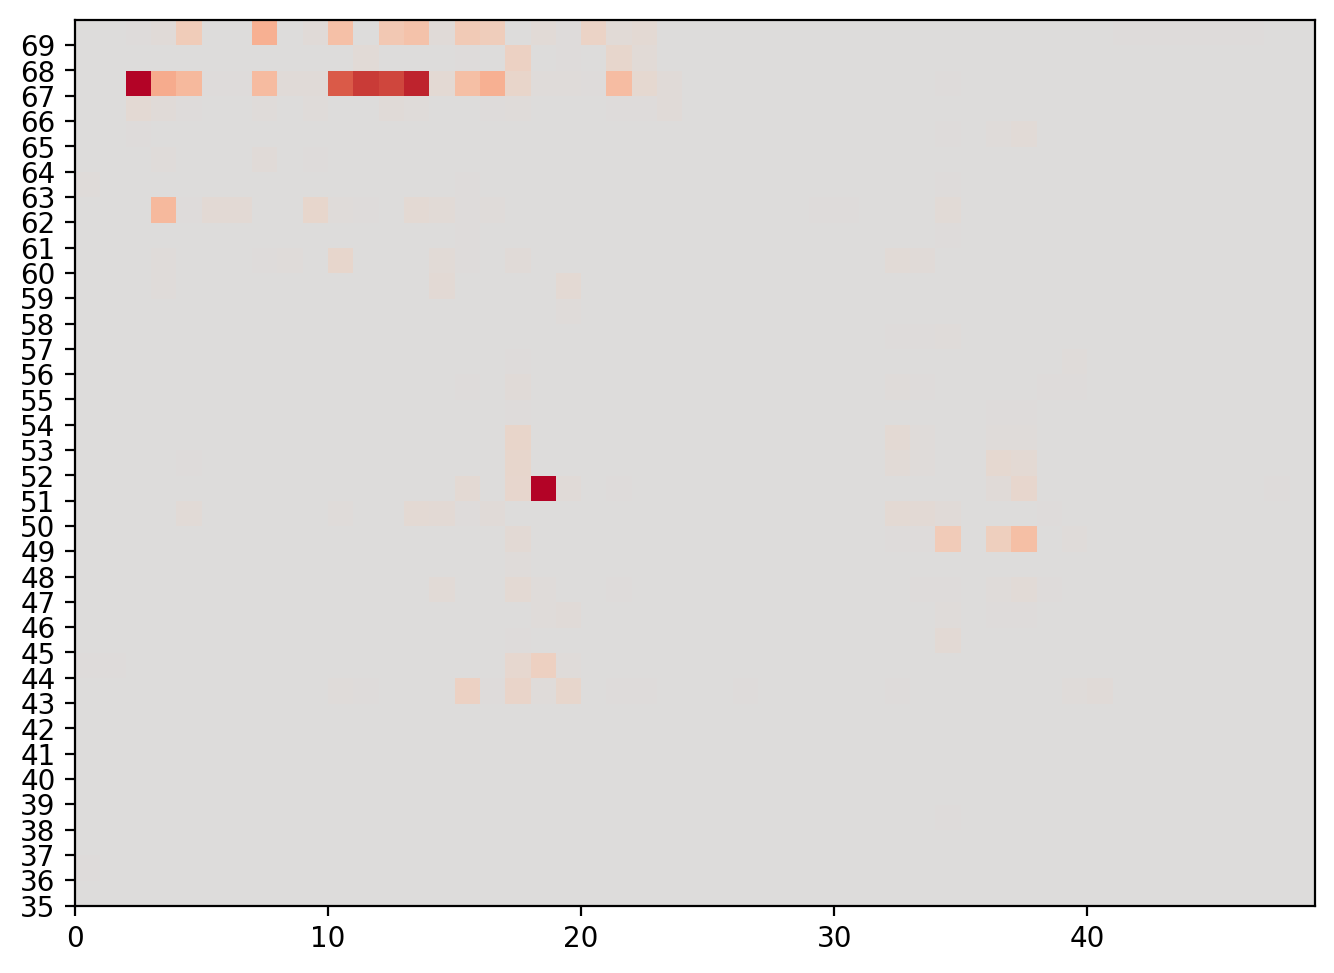

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

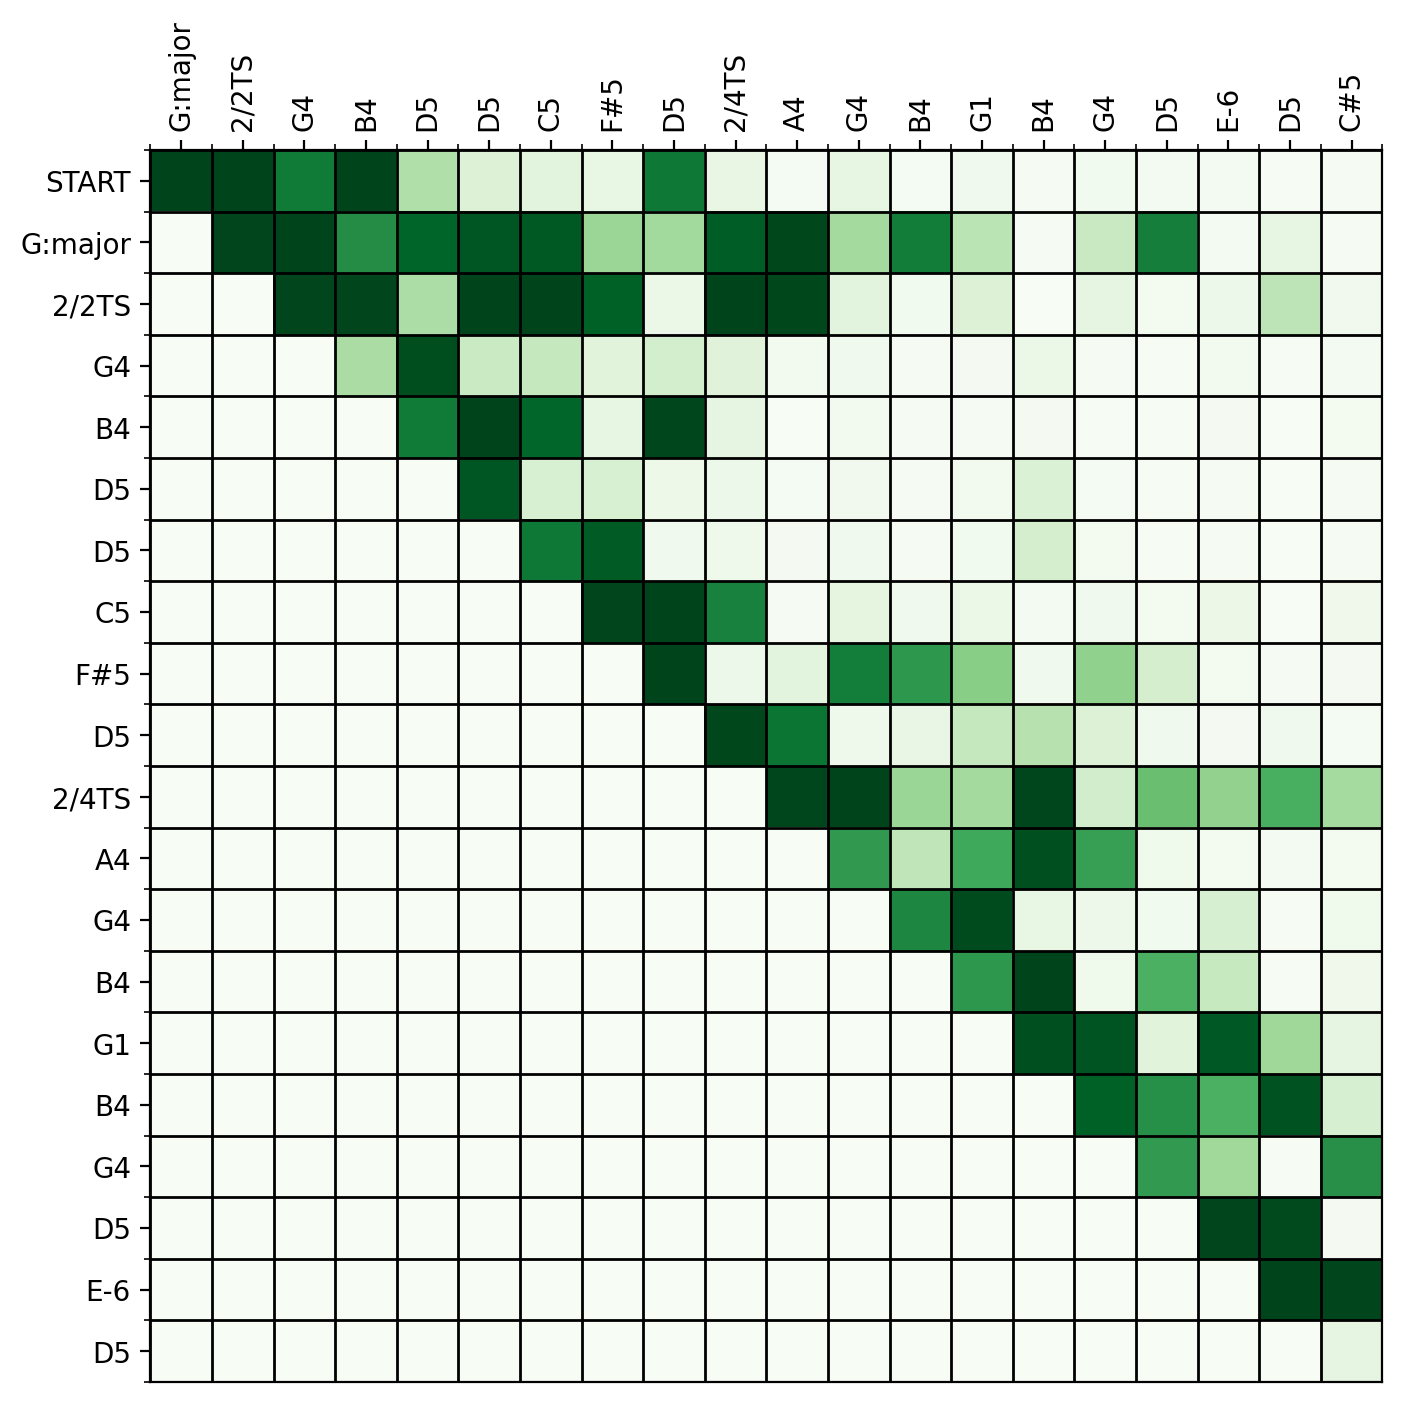

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output1", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output2", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output3", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")

'/content/data.zip'

In [ ]:
# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output1 /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output2 /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output3 /content/drive/MyDrive/GenAI

Discussion Points:

Looking at the generated music, it has a lot of the same issues that the previous model had. The music jumps around a lot with its notes and most of the generated music consists of 16th notes with not that much variation, especially in the latter half of the generated music. Looking at temperature, I noticed that with the generated music with temperature of 0.1, there are a lot more jumps between notes with the jumps being bigger than with the music with a higher temperature. The generated music doesn't resemble Beethoven's music that much. His music has less jumps than the generated music and has more variation in the length of notes used istead of mainly using 16th notes.